In [5]:
from jax.random import PRNGKey, randint, uniform, split, permutation
import jax.numpy as jnp
import jax.dlpack
from jax.lax import scan
from jax import vmap, jit, value_and_grad

import os
import matplotlib.pyplot as plt
import numpy as np
import struct
import tensorflow as tf
import tensorflow_probability as tfp

from jax.scipy.special import expit, logit
from jax.nn import softmax
from jax.example_libraries import optimizers

import distrax
from distrax._src.utils import jittable
import itertools

tfd = tfp.distributions

In [6]:
class MixtureSameFamily(distrax.MixtureSameFamily):

    def _per_mixture_component_log_prob(self, value):
        # Add component axis to make input broadcast with components distribution.
        expanded = jnp.expand_dims(value, axis=-1 - len(self.event_shape))
        # Compute `log_prob` in every component.
        lp = self.components_distribution.log_prob(expanded)
        # Last batch axis is number of components, i.e. last axis of `lp` below.
        # Last axis of mixture log probs are components.
        return lp + self._mixture_log_probs

    def log_prob(self, value):
        # Reduce last axis of mixture log probs are components
        return jax.scipy.special.logsumexp(self._per_mixture_component_log_prob(value), axis=-1)

    def posterior_marginal(self, observations):
        return distrax.Categorical(logits=self._per_mixture_component_log_prob(observations))

    def posterior_mode(self, observations):
        return jnp.argmax(self._per_mixture_component_log_prob(observations), axis=-1)


In [7]:
# Implementation of Bernoulli Mixture Model
# Author : Aleyna Kara(@karalleyna)


opt_init, opt_update, get_params = optimizers.adam(1e-1)


class BMM(jittable.Jittable):
    def __init__(self, K, n_vars, rng_key=None):
        rng_key = PRNGKey(0) if rng_key is None else rng_key

        mixing_coeffs = uniform(rng_key, (K,), minval=100, maxval=200)
        mixing_coeffs = mixing_coeffs / mixing_coeffs.sum()
        initial_probs = jnp.full((K, n_vars), 1.0 / K)

        self._probs = initial_probs
        self.model = (mixing_coeffs, initial_probs)

    @property
    def mixing_coeffs(self):
        return self._model.mixture_distribution.probs

    @property
    def probs(self):
        return self._probs

    @property
    def model(self):
        return self._model

    @model.setter
    def model(self, value):
        mixing_coeffs, probs = value
        self._model = MixtureSameFamily(
            mixture_distribution=distrax.Categorical(probs=mixing_coeffs),
            components_distribution=distrax.Independent(distrax.Bernoulli(probs=probs)),
        )

    def responsibilities(self, observations):
        return jnp.nan_to_num(self._model.posterior_marginal(observations).probs)

    def expected_log_likelihood(self, observations):
        return jnp.sum(jnp.nan_to_num(self._model.log_prob(observations)))

    def _m_step(self, observations):
        n_obs, _ = observations.shape

        # Computes responsibilities, or posterior probability p(z|x)
        def m_step_per_bernoulli(responsibility):
            norm_const = responsibility.sum()
            mu = jnp.sum(responsibility[:, None] * observations, axis=0) / norm_const
            return mu, norm_const

        mus, ns = vmap(m_step_per_bernoulli, in_axes=(1))(
            self.responsibilities(observations)
        )
        return ns / n_obs, mus

    def fit_em(self, observations, num_of_iters=10):
        
        iterations = jnp.arange(num_of_iters)

        def train_step(params, i):
            self.model = params

            log_likelihood = self.expected_log_likelihood(observations)
            responsibilities = self.responsibilities(observations)

            mixing_coeffs, probs = self._m_step(observations)

            return (mixing_coeffs, probs), (log_likelihood, responsibilities)

        initial_params = (self.mixing_coeffs, self.probs)

        final_params, history = scan(train_step, initial_params, iterations)

        self.model = final_params
        _, probs = final_params
        self._probs = probs

        ll_hist, responsibility_hist = history

        ll_hist = jnp.append(ll_hist, self.expected_log_likelihood(observations))
        responsibility_hist = jnp.vstack(
            [responsibility_hist, jnp.array([self.responsibilities(observations)])]
        )

        return ll_hist, responsibility_hist

    def _make_minibatches(self, observations, batch_size, rng_key):
        
        num_train = len(observations)
        perm = permutation(rng_key, num_train)

        def create_mini_batch(batch_idx):
            return observations[batch_idx]

        num_batches = num_train // batch_size
        batch_indices = perm.reshape((num_batches, -1))
        minibatches = vmap(create_mini_batch)(batch_indices)

        return minibatches

    @jit
    def loss_fn(self, params, batch):
        
        mixing_coeffs, probs = params
        self.model = (softmax(mixing_coeffs), expit(probs))
        return -self.expected_log_likelihood(batch) / len(batch)

    @jit
    def update(self, i, opt_state, batch):
        
        params = get_params(opt_state)
        loss, grads = value_and_grad(self.loss_fn)(params, batch)
        return opt_update(i, grads, opt_state), loss

    def fit_sgd(
        self, observations, batch_size, rng_key=None, optimizer=None, num_epochs=1
    ):
        global opt_init, opt_update, get_params

        if rng_key is None:
            rng_key = PRNGKey(0)

        if optimizer is not None:
            opt_init, opt_update, get_params = optimizer
        opt_state = opt_init((softmax(self.mixing_coeffs), logit(self.probs)))
        itercount = itertools.count()
        def epoch_step(opt_state, key):
            def train_step(opt_state, batch):
                opt_state, loss = self.update(next(itercount), opt_state, batch)
                return opt_state, loss

            batches = self._make_minibatches(observations, batch_size, key)
            opt_state, losses = scan(train_step, opt_state, batches)

            params = get_params(opt_state)
            mixing_coeffs, probs_logits = params
            probs = expit(probs_logits)
            self.model = (softmax(mixing_coeffs), probs)
            self._probs = probs

            return opt_state, (
                losses.mean(),
                *params,
                self.responsibilities(observations),
            )

        epochs = split(rng_key, num_epochs)
        opt_state, history = scan(epoch_step, opt_state, epochs)
        params = get_params(opt_state)
        mixing_coeffs, probs_logits = params
        probs = expit(probs_logits)
        self.model = (softmax(mixing_coeffs), probs)
        self._probs = probs
        return history

    def plot(self, n_row, n_col, file_name):
        if n_row * n_col != len(self.mixing_coeffs):
            raise TypeError(
                "The number of rows and columns does not match with the number of component distribution."
            )
        fig, axes = plt.subplots(n_row, n_col)

        for (coeff, mean), ax in zip(
            zip(self.mixing_coeffs, self.probs), axes.flatten()
        ):
            # print(mean)
            ax.imshow(mean.reshape(28, 28), cmap=plt.cm.gray)
            ax.set_title("%1.2f" % coeff)
            ax.axis("off")

        fig.tight_layout(pad=1.0)
        # pml.savefig(f"{file_name}.pdf")
        plt.show()


[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.001      0.001      0.002      0.002
 0.002      0.004      0.003      0.001      0.001      0.001
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.001      0.00300001
 0.00700002 0.01000003 0.01600004 0.01800002 0.02500002 0.027
 0.02400001 0.02300002 0.02000001 0.01600001 0.008      0.003
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.00300001 0.00800003 0.01500006 0.02400009 0.03500012
 0.05300012 0.06700011 0.079

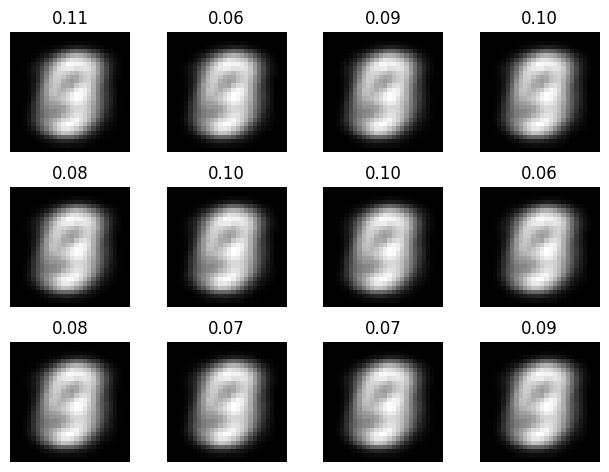

In [8]:
n_obs = 1000
rng_key = PRNGKey(0)

(x_train, y_train), _ = tf.keras.datasets.mnist.load_data()
x = (x_train > 0).astype('int')  # Converting to binary
dataset_size = x.shape[0]

perm = randint(rng_key, minval=0, maxval=dataset_size, shape=((n_obs,)))
x_train = x[perm]
x_train = x_train.reshape((n_obs, 784))

observations = x_train # subsample the MNIST dataset
n_vars = len(observations[0])
# print(n_vars)
K, num_of_iters = 12, 1
n_row, n_col = 3, 4
bmm = BMM(K, n_vars)
# print(observations.shape)
_ = bmm.fit_em(observations, num_of_iters=num_of_iters)
bmm.plot(n_row, n_col, "bmm_em_mnist")



[5.90705080e-04 5.90705080e-04 5.90705080e-04 5.90705080e-04
 5.90705080e-04 5.90705080e-04 5.90705080e-04 5.90705080e-04
 5.90705080e-04 5.90705080e-04 5.90705080e-04 5.90705080e-04
 5.90705080e-04 5.90705080e-04 5.90705080e-04 5.90705080e-04
 5.90705080e-04 5.90705080e-04 5.90705080e-04 5.90705080e-04
 5.90705080e-04 5.90705080e-04 5.90705080e-04 5.90705080e-04
 5.90705080e-04 5.90705080e-04 5.90705080e-04 5.90705080e-04
 5.90705080e-04 5.90705080e-04 5.90705080e-04 5.90705080e-04
 5.90705080e-04 5.90705080e-04 5.90705080e-04 5.90705080e-04
 5.90705080e-04 5.90705080e-04 5.90705080e-04 5.90705080e-04
 5.90705080e-04 5.90705080e-04 5.90705080e-04 5.90705080e-04
 5.90705080e-04 5.90705080e-04 5.90705080e-04 5.90705080e-04
 5.90705080e-04 5.90705080e-04 5.90705080e-04 5.90705080e-04
 5.90705080e-04 5.90705080e-04 5.90705080e-04 5.90705080e-04
 5.90705080e-04 5.90705080e-04 5.90705080e-04 5.90705080e-04
 5.90705080e-04 5.90705080e-04 5.90705080e-04 5.90705080e-04
 5.90705080e-04 5.166444

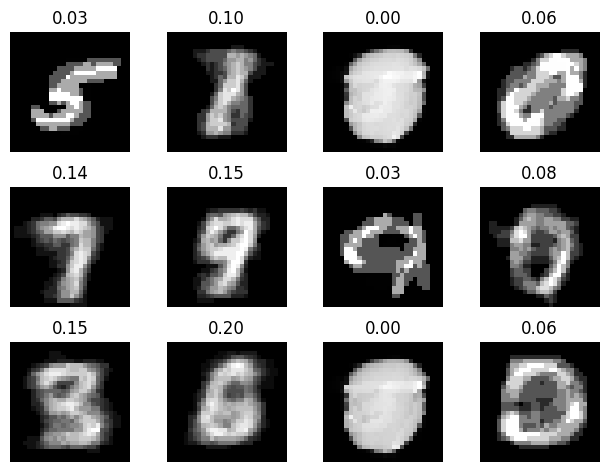

In [9]:
n_obs = 100
rng_key = PRNGKey(0)

(x_train, y_train), _ = tf.keras.datasets.mnist.load_data()
x = (x_train > 0).astype('int')  # Converting to binary
dataset_size = x.shape[0]

perm = randint(rng_key, minval=0, maxval=dataset_size, shape=((n_obs,)))
x_train = x[perm]
x_train = x_train.reshape((n_obs, 784))

observations = x_train # subsample the MNIST dataset
n_vars = len(observations[0])
# print(n_vars)
K, num_of_iters = 12, 1
n_row, n_col = 3, 4
bmm1 = BMM(K, n_vars)
num_epochs = 500
bmm1.fit_sgd(jnp.array(observations), batch_size=n_obs, num_epochs=num_epochs)
bmm1.plot(n_row, n_col, "bmm_sgd_mnist")

In [4]:
import tensorflow as tf
from tensorflow import keras

def make_model(input_dimension,embed_size):
    tf.random.set_seed(42)
    np.random.seed(42)
    model = keras.Sequential()
    model.add(keras.layers.Embedding(input_dimension, embed_size))
    model.add(keras.layers.GlobalAveragePooling1D())
    model.add(keras.layers.Dense(16, activation=tf.nn.relu))
    model.add(keras.layers.Dense(1, activation=tf.nn.sigmoid))
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["acc"])
    return model
# 28*28
input_dimension = 784
embed_size = 16
model = make_model(input_dimension, embed_size)
model.summary()


NameError: name 'np' is not defined